# Data Source

- [AIHub: 한국인 전신 형상 및 치수 측정 데이터(성인)](https://www.aihub.or.kr/aihubdata/data/view.do?currMenu=&topMenu=&aihubDataSe=data&dataSetSn=560)

# Import Library

In [206]:
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
import shutil

# Function

In [207]:
def create_images_path(folder_name):
    currnet_path = os.getcwd()
    folder_path = os.path.join(currnet_path, folder_name)
    imges = os.listdir(folder_path)
    
    images_path = [os.path.join(folder_path, img) for img in imges]
    
    return images_path

In [208]:
def show_images(images_path, visualize=1, rotate=0): # Outputs\\01_01_F010_02.png, rotate 회전각 입력
    # Output
    images_names = []
    images_array = []
    
    for img in tqdm(images_path, desc="Processing images"):
        image_path = img
        image_name = os.path.basename(image_path)

        image = Image.open(image_path)

        # 이미지 회전 메타데이터를 자동으로 해석하여 회전시킴
        image = image.rotate(rotate, expand=True)  # 0은 회전 각도, expand=True는 이미지 크기 조정 (0 / 270)

        images_names.append(image_name)
        image_array = np.array(image)
        images_array.append(image_array)

        # Visualize Images -------------------> Option(On/Off)
        if visualize:
            print("Size of Image:", image.size)
            print("Mode of Image:", image.mode) # (RGB/L/P)
            plt.imshow(image)
            plt.title(f'{image_name}')
            plt.axis('off')  # 축 제거
            plt.show()
    else:
        pass

    return images_names, images_array

In [209]:
Index2Label = {0: 'Background', 
               1: 'Head', 
               2: 'Torso', 
               3: 'Upper_Arms', 
               4: 'Lower_Arms', 
               5: 'Upper_Legs', 
               6: 'Lower_Legs'}

Label2Index = {'Background': 0, 
               'Head': 1, 
               'Torso': 2, 
               'Upper_Arms': 3, 
               'Lower_Arms': 4, 
               'Upper_Legs': 5, 
               'Lower_Legs': 6}

# Label2Index = {v: k for k, v in Index2Label.items()}

In [210]:
def visualize_segmentation(single_segmentation, Index2Label=Index2Label):
    image_array = single_segmentation
    index_lst = np.unique(image_array)
    index_lst = np.sort(index_lst)

    print(f'Indices of Image: {index_lst}')
    
    for index in tqdm(index_lst, desc="Visualizing Segmentation"):
        indices = np.argwhere(image_array == index)
        plt.figure()
        
        # 각 픽셀에 대해 새로운 이미지 생성
        segmented_image = np.zeros_like(image_array)
        for idx in indices:
            segmented_image[idx[0], idx[1]] = image_array[idx[0], idx[1]]
        
        plt.imshow(segmented_image) # cmap='gray'
        plt.title(f'Pixel Values: {index}  {Index2Label[index]}')
        plt.axis('off')

    plt.show()
    
    return index_lst

In [211]:
def clip_and_pad_single_image(image_path, clip_top, clip_bottom, clip_left, clip_right, visualize=True):
    """
    단일 이미지를 클리핑하고 패딩을 적용하여 원본 이미지와 동일한 비율과 크기의 이미지를 생성하고 반환
    
    Parameters:
        image_path (str): 원본 이미지 파일 경로
        clip_top (int): 상단에서 클리핑할 길이
        clip_bottom (int): 하단에서 클리핑할 길이
        clip_left (int): 왼쪽에서 클리핑할 길이
        clip_right (int): 오른쪽에서 클리핑할 길이
        visualize (bool): 시각화 기능을 사용할지 여부 (기본값: True)
    
    Returns:
        PIL.Image.Image: 팔레트 정보와 함께 변환된 PIL 이미지
    """
    # 이미지 처리 함수
    def process_image(image, clip_top, clip_bottom, clip_left, clip_right):
        # Image shape
        height, width = image.shape[:2]
        
        # 클리핑된 이미지의 높이와 너비 계산
        clipped_height = height - clip_top - clip_bottom
        clipped_width = width - clip_left - clip_right
        
        # 클리핑된 부분과 동일한 크기의 이미지를 만들고 클리핑된 부분에 원본 이미지 값 복사
        clipped_image = np.zeros((clipped_height, clipped_width), dtype=np.uint8)
        clipped_image = image[clip_top:clip_top+clipped_height, clip_left:clip_left+clipped_width]
        
        # 패딩된 이미지 생성 (클리핑 부분 외에는 0(배경)으로 채움)
        padded_image = np.zeros_like(image)
        padded_image[clip_top:clip_top+clipped_height, clip_left:clip_left+clipped_width] = clipped_image
        
        return clipped_image, padded_image
    
    # NumPy 배열을 원본 이미지의 팔레트 정보와 함께 PIL 이미지로 변환하는 함수
    def numpy_to_pil_with_palette(image_array, palette):
        pil_image = Image.fromarray(image_array)
        pil_image.putpalette(palette)
        return pil_image
    
    # 이미지 열기
    with Image.open(image_path) as img:
        # 팔레트 모드 유지
        img = img.convert('P')
        # Image --> Numpy
        image = np.array(img)
    
    # 팔레트 정보 추출
    palette = img.getpalette()
    
    # 이미지 처리
    clipped_image, padded_image = process_image(image, clip_top, clip_bottom, clip_left, clip_right)
    
    # 시각화
    if visualize:
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        
        # 원본 이미지 시각화
        axes[0].imshow(numpy_to_pil_with_palette(image, palette))
        axes[0].set_title(f'Original Image\nShape: {image.shape}')
        axes[0].axis('off')
        
        # 클리핑된 부분 시각화
        axes[1].imshow(numpy_to_pil_with_palette(clipped_image, palette))
        axes[1].set_title(f'Clipped Area\nShape: {clipped_image.shape}')
        axes[1].axis('off')
        
        # 패딩된 이미지 시각화
        axes[2].imshow(numpy_to_pil_with_palette(padded_image, palette))
        axes[2].set_title(f'Padded Image\nShape: {padded_image.shape}')
        axes[2].axis('off')
        
        plt.show()
    
    # 팔레트를 이용하여 PIL 이미지로 반환
    padded_img_pil = numpy_to_pil_with_palette(padded_image, palette)
    
    return padded_img_pil


In [226]:
def process_images_in_folder(input_folder, output_folder, clip_top, clip_bottom, clip_left, clip_right, visualize=False):
    """
    입력 폴더의 이미지들을 클리핑하고 패딩하여 출력 폴더에 저장하는 함수
    
    Parameters:
        input_folder (str): 입력 이미지가 있는 폴더 경로
        output_folder (str): 처리된 이미지를 저장할 폴더 경로
        clip_top (int): 상단에서 클리핑할 길이
        clip_bottom (int): 하단에서 클리핑할 길이
        clip_left (int): 왼쪽에서 클리핑할 길이
        clip_right (int): 오른쪽에서 클리핑할 길이
    """
    # 출력 폴더가 없는 경우 생성
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    
    # 입력 폴더의 모든 파일 탐색
    for filename in tqdm(os.listdir(input_folder), desc="Processing images"):
        # 파일 경로 생성
        input_path = os.path.join(input_folder, filename)
        
        # 이미지 파일인지 확인
        if os.path.isfile(input_path) and filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            # 이미지 처리
            padded_img_pil = clip_and_pad_single_image(input_path, clip_top, clip_bottom, clip_left, clip_right, visualize)
            
            # 출력 파일 경로 생성
            output_path = os.path.join(output_folder, filename)
            
            # 이미지 저장
            padded_img_pil.save(output_path)


# Task

#### 4개의 폴더를 하나의 폴더로 병합하였음 (Inspection_Seg_02_23_1)

In [213]:
cwd_path = os.getcwd() # 'd:\\알파코\\SCHP\\Inspection_Seg'
Inspection_Seg_02_23 = os.path.join(cwd_path, 'Inspection_Seg_02_23')

seg_img_folders = os.listdir(Inspection_Seg_02_23) # ['seg_1', 'seg_2', 'seg_3', 'seg_4']

In [214]:
path = "D:\알파코\SCHP\Inspection_Seg\Inspection_Seg_02_23" 

count_img = []

for folder in seg_img_folders:
    # print(folder)
    seg_img_path = os.path.join(path, folder)
    seg_imgs = os.listdir(seg_img_path)
    count_img.append(len(seg_imgs))
    
count_img

[3309, 8155, 3742, 6961]

In [215]:
count_merge = len( os.listdir(cwd_path + "\\Inspection_Seg_02_23_1"))
count_merge

22167

In [216]:
sum(count_img) == count_merge

True

#### 촬영 각도로 이미지 나누기

- [표 4] 촬영 자세 
    - [2-01-151] 한국인 전신 형상 및 치수 측정 데이터 - 데이터구축가이드라인_v2.0

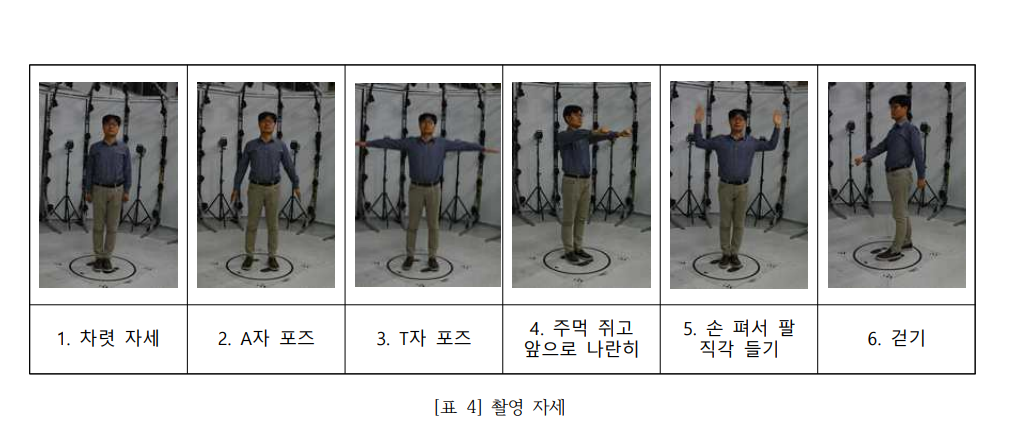

- 촬영 각도: 1 ~ 32 (32개)

In [217]:
seg_img_folder = "D:\알파코\SCHP\Inspection_Seg\Inspection_Seg_02_23_1"
seg_img_path = os.listdir(seg_img_folder)

len(seg_img_path) # 22167

22167

In [218]:
# 이미지가 저장된 디렉토리 경로
source_directory = 'D:\\알파코\\SCHP\\Inspection_Seg\\Inspection_Seg_02_23_1'

# 이미지를 복사할 디렉토리 경로
destination_parent_directory =  "D:\알파코\SCHP\Inspection_Seg" + "\\02_24_inspect"
os.makedirs(destination_parent_directory, exist_ok=True)

# 이미지 읽기
image_files = os.listdir(source_directory)

In [219]:
# 이미지를 그룹화하고 그룹별로 이미지를 복사하며 각 그룹의 이미지 개수 출력
groups = {}
for file_name in image_files:
    group_name = file_name[-6:-4]  # 파일 이름에서 끝의 두 자리 추출 (촬영각도)
    groups.setdefault(group_name, []).append(file_name)

for group_name, group_files in tqdm(groups.items(), desc="Copying images"):
    # 폴더 생성
    destination_directory = os.path.join(destination_parent_directory, group_name)
    os.makedirs(destination_directory, exist_ok=True)

    # 해당하는 그룹의 이미지 파일을 찾아서 복사하고 이미지 개수 출력
    for file_name in group_files:
        source_file_path = os.path.join(source_directory, file_name)
        destination_file_path = os.path.join(destination_directory, file_name)
        shutil.copy(source_file_path, destination_file_path)

    print(f'그룹 {group_name}에 속하는 이미지 개수:', len(group_files))

Copying images:   3%|▎         | 1/32 [00:00<00:22,  1.37it/s]

그룹 01에 속하는 이미지 개수: 872


Copying images:   6%|▋         | 2/32 [00:01<00:18,  1.63it/s]

그룹 08에 속하는 이미지 개수: 674


Copying images:   9%|▉         | 3/32 [00:01<00:15,  1.82it/s]

그룹 13에 속하는 이미지 개수: 589


Copying images:  12%|█▎        | 4/32 [00:02<00:15,  1.81it/s]

그룹 14에 속하는 이미지 개수: 713


Copying images:  16%|█▌        | 5/32 [00:02<00:15,  1.69it/s]

그룹 16에 속하는 이미지 개수: 823


Copying images:  19%|█▉        | 6/32 [00:03<00:15,  1.72it/s]

그룹 17에 속하는 이미지 개수: 717


Copying images:  22%|██▏       | 7/32 [00:04<00:15,  1.60it/s]

그룹 18에 속하는 이미지 개수: 872


Copying images:  25%|██▌       | 8/32 [00:05<00:16,  1.46it/s]

그룹 19에 속하는 이미지 개수: 977


Copying images:  28%|██▊       | 9/32 [00:05<00:15,  1.46it/s]

그룹 20에 속하는 이미지 개수: 895


Copying images:  31%|███▏      | 10/32 [00:06<00:13,  1.64it/s]

그룹 22에 속하는 이미지 개수: 549


Copying images:  34%|███▍      | 11/32 [00:06<00:12,  1.63it/s]

그룹 23에 속하는 이미지 개수: 823


Copying images:  38%|███▊      | 12/32 [00:07<00:12,  1.60it/s]

그룹 24에 속하는 이미지 개수: 858


Copying images:  41%|████      | 13/32 [00:07<00:10,  1.79it/s]

그룹 26에 속하는 이미지 개수: 542


Copying images:  44%|████▍     | 14/32 [00:08<00:09,  1.90it/s]

그룹 32에 속하는 이미지 개수: 600


Copying images:  47%|████▋     | 15/32 [00:08<00:09,  1.76it/s]

그룹 02에 속하는 이미지 개수: 894


Copying images:  50%|█████     | 16/32 [00:09<00:08,  1.79it/s]

그룹 03에 속하는 이미지 개수: 700


Copying images:  53%|█████▎    | 17/32 [00:10<00:08,  1.80it/s]

그룹 04에 속하는 이미지 개수: 705


Copying images:  56%|█████▋    | 18/32 [00:10<00:07,  1.78it/s]

그룹 06에 속하는 이미지 개수: 680


Copying images:  59%|█████▉    | 19/32 [00:11<00:07,  1.77it/s]

그룹 05에 속하는 이미지 개수: 749


Copying images:  62%|██████▎   | 20/32 [00:11<00:06,  1.87it/s]

그룹 07에 속하는 이미지 개수: 602


Copying images:  66%|██████▌   | 21/32 [00:12<00:06,  1.76it/s]

그룹 15에 속하는 이미지 개수: 847


Copying images:  69%|██████▉   | 22/32 [00:12<00:05,  1.99it/s]

그룹 25에 속하는 이미지 개수: 456


Copying images:  72%|███████▏  | 23/32 [00:13<00:04,  2.06it/s]

그룹 31에 속하는 이미지 개수: 585


Copying images:  75%|███████▌  | 24/32 [00:13<00:03,  2.03it/s]

그룹 29에 속하는 이미지 개수: 690


Copying images:  78%|███████▊  | 25/32 [00:14<00:03,  1.96it/s]

그룹 30에 속하는 이미지 개수: 710


Copying images:  81%|████████▏ | 26/32 [00:14<00:03,  1.90it/s]

그룹 21에 속하는 이미지 개수: 671


Copying images:  84%|████████▍ | 27/32 [00:15<00:02,  2.08it/s]

그룹 09에 속하는 이미지 개수: 500


Copying images:  88%|████████▊ | 28/32 [00:15<00:01,  2.14it/s]

그룹 10에 속하는 이미지 개수: 573


Copying images:  91%|█████████ | 29/32 [00:15<00:01,  2.22it/s]

그룹 12에 속하는 이미지 개수: 555


Copying images:  94%|█████████▍| 30/32 [00:16<00:00,  2.24it/s]

그룹 28에 속하는 이미지 개수: 585


Copying images:  97%|█████████▋| 31/32 [00:16<00:00,  2.28it/s]

그룹 27에 속하는 이미지 개수: 538


Copying images: 100%|██████████| 32/32 [00:17<00:00,  1.85it/s]

그룹 11에 속하는 이미지 개수: 623


In [237]:
path = r"D:\알파코\SCHP\Inspection_Seg\02_24_inspect"
angles = os.listdir(path)

angle_count = []
for idx, angle in enumerate(angles):
    angle_path = os.path.join(path, angle)
    count_angle = len(os.listdir(angle_path))
    print(f'angle: {angle} count: {count_angle}')
    angle_count.append(count_angle)
    
print(f'\nTotal count : {sum(angle_count)}')

angle: 01 count: 872
angle: 02 count: 894
angle: 03 count: 700
angle: 04 count: 705
angle: 05 count: 749
angle: 06 count: 680
angle: 07 count: 602
angle: 08 count: 674
angle: 09 count: 500
angle: 10 count: 573
angle: 11 count: 623
angle: 12 count: 555
angle: 13 count: 589
angle: 14 count: 713
angle: 15 count: 847
angle: 16 count: 823
angle: 17 count: 717
angle: 18 count: 872
angle: 19 count: 977
angle: 20 count: 895
angle: 21 count: 671
angle: 22 count: 549
angle: 23 count: 823
angle: 24 count: 858
angle: 25 count: 456
angle: 26 count: 542
angle: 27 count: 538
angle: 28 count: 585
angle: 29 count: 690
angle: 30 count: 710
angle: 31 count: 585
angle: 32 count: 600

Total count : 22167


#### 이미지 크롭

In [220]:
base_path = r"D:\알파코\SCHP\Inspection_Seg\02_24_inspect"

imges_path = []
for folder in os.listdir(base_path):
    folder_path = os.path.join(base_path, folder)
    
    imge_path = [os.path.join(folder_path, img) for img in os.listdir(folder_path)] #r개별 이미지 경로 추가
    
    imges_path.append(imge_path) # 촬용 각도별 이미지 경로 추가

print(len(imges_path), '\n')

32 



##### 각도별 이미지 확인

각도 1번

Processing images:   0%|          | 0/1 [00:00<?, ?it/s]

Size of Image: (1960, 2940)
Mode of Image: P


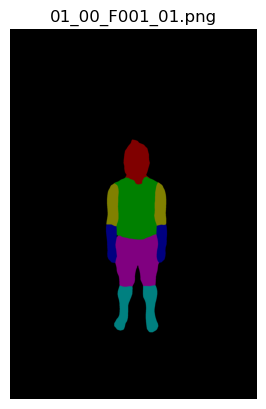

Processing images: 100%|██████████| 1/1 [00:00<00:00,  3.12it/s]


In [221]:
images_names, images_array = show_images(imges_path[0][0:1], visualize=1)

In [222]:
images_names, images_array = show_images(imges_path[0], visualize=0) # 각도 1번

Processing images: 100%|██████████| 872/872 [00:09<00:00, 95.27it/s] 


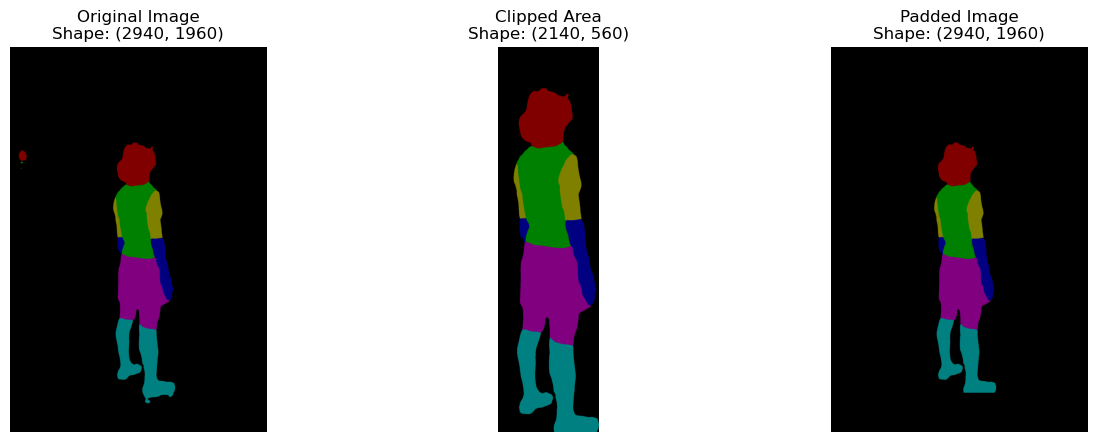

In [223]:
image_path = r"D:\알파코\SCHP\Jay's_code\원본라벨링_02_20\01_04_F018_23.png"

test_image = clip_and_pad_single_image(image_path, 500, 300, 700, 700, visualize=1)

Indices of Image: [0 1 2 3 4 5 6]


Visualizing Segmentation:   0%|          | 0/7 [00:00<?, ?it/s]

Visualizing Segmentation: 100%|██████████| 7/7 [00:02<00:00,  2.39it/s]


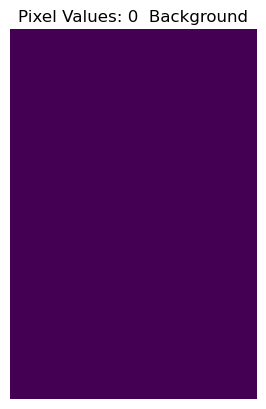

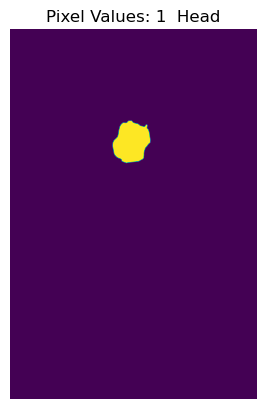

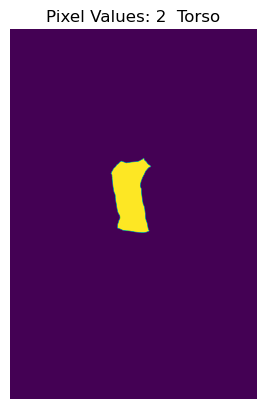

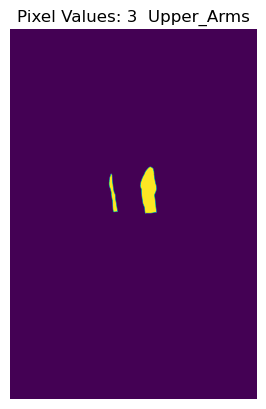

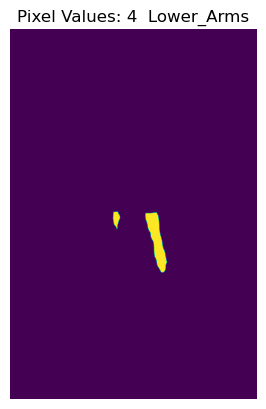

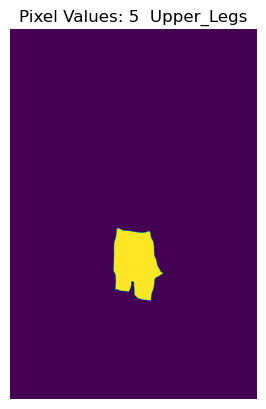

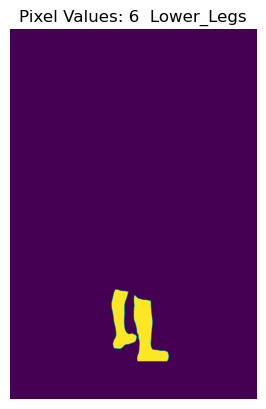

array([0, 1, 2, 3, 4, 5, 6], dtype=uint8)

In [224]:
test_image_array = np.array(test_image)

visualize_segmentation(test_image_array)

#### Test

Processing images:   0%|          | 0/4 [00:00<?, ?it/s]

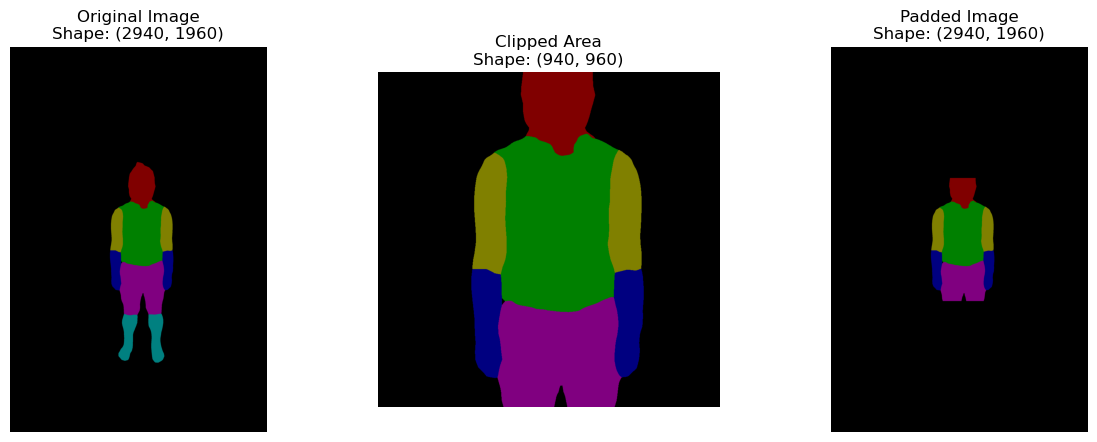

Processing images:  25%|██▌       | 1/4 [00:00<00:02,  1.25it/s]

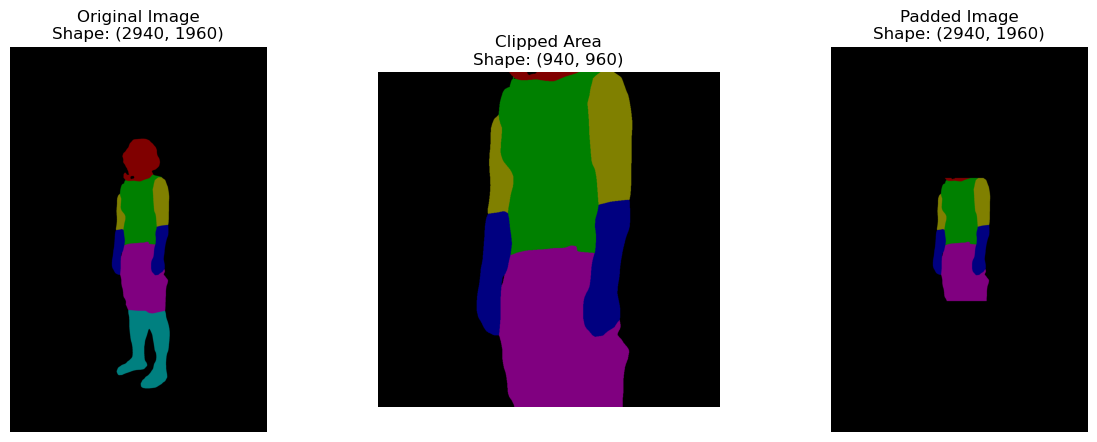

Processing images:  50%|█████     | 2/4 [00:01<00:01,  1.36it/s]

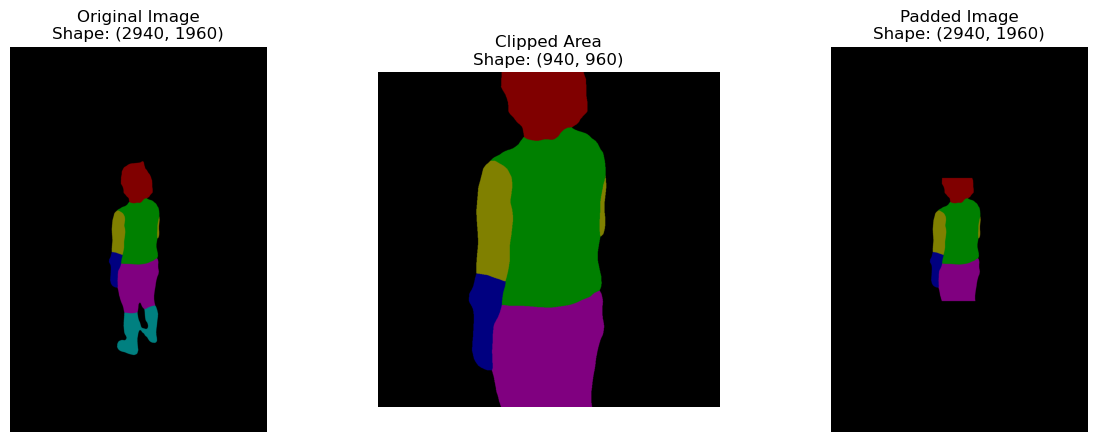

Processing images:  75%|███████▌  | 3/4 [00:02<00:00,  1.38it/s]

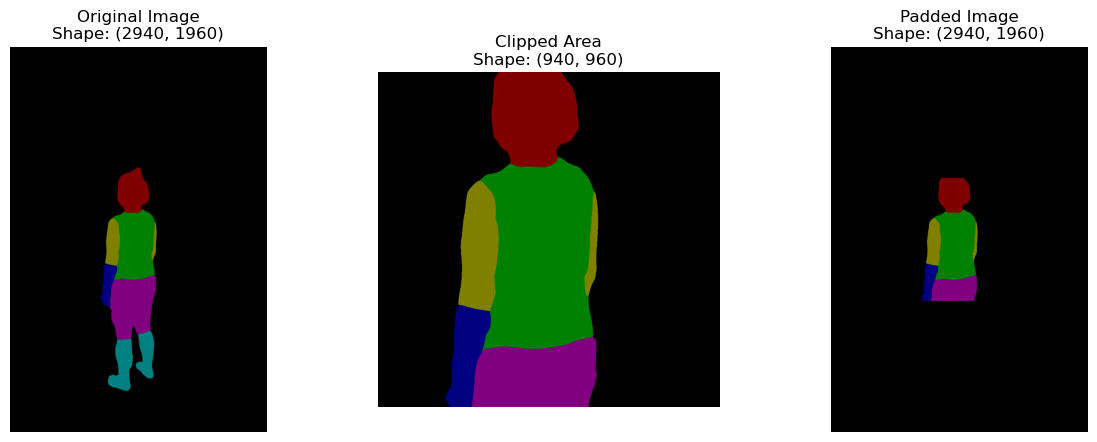

Processing images: 100%|██████████| 4/4 [00:02<00:00,  1.38it/s]


In [227]:
# 예시: 이미지가 있는 폴더와 새롭게 저장할 폴더 경로 설정
input_folder_path = r"D:\알파코\SCHP\Inspection_Seg\Test"
output_folder_path = r"D:\알파코\SCHP\Inspection_Seg\Test_Result"

# 클리핑 및 패딩할 길이 설정
clip_top = 1000
clip_bottom = 1000
clip_left = 500
clip_right = 500

# 이미지 처리 함수 호출
process_images_in_folder(input_folder_path, output_folder_path, clip_top, clip_bottom, clip_left, clip_right, visualize=True)